<a href="https://colab.research.google.com/github/mmaghajani/RL-up-running/blob/main/DQN_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [1]:
!pip install -q mujoco_py==2.0.2.8
!pip install -q 'gym[all]'

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 204 kB 39.6 MB/s 
     |████████████████████████████████| 448 kB 5.2 MB/s 
     |████████████████████████████████| 120 kB 66.1 MB/s 
  ERROR: Failed building wheel for mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-x1b0oafv/mujoco-py_a5b1baae93fd4eb78c63cfd3b53bf7f9/setup.py'"'"'; __file__='"'"'/tmp/pip-install-x1b0oafv/mujoco-py_a5b1baae93fd4eb78c63cfd3b53bf7f9/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-j6kawmpm/install-record.txt --single-version-externally-managed --c

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

### Replay Buffer

In [3]:
class ReplayBuffer():
    def __init__(self,mem_size,input_dim):
        self.mem_size = mem_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size,*input_dim),dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size,*input_dim),dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size,dtype=np.int32)
        self.reward_memory =  np.zeros(self.mem_size,dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size,dtype=np.int32)
        
    def store_transition(self,state,action,reward,next_state,done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.action_memory[index] = action 
        self.reward_memory[index] = reward 
        self.terminal_memory[index] = 1-int(done)
        self.mem_cntr +=1
        
    def sample_buffer(self,batch_size):
        max_mem = min(self.mem_cntr,self.mem_size)
        batch = np.random.choice(max_mem,batch_size,replace=False)
        
        states = self.state_memory[batch] 
        next_states = self.new_state_memory[batch] 
        actions = self.action_memory[batch] 
        rewards = self.reward_memory[batch] 
        terminals = self.terminal_memory[batch]
        return states,actions,rewards,next_states,terminals
    
        
        
        

### Build Deep-q Network

In [4]:
def build_dqn(lr,n_actions,input_dims,fc1_dims,fc2_dims):
    model = keras.Sequential()
    model.add(keras.layers.Dense(fc1_dims,activation='relu'))
    model.add(keras.layers.Dense(fc2_dims,activation='relu'))
    model.add(keras.layers.Dense(n_actions,activation=None))
    model.compile(optimizer=Adam(learning_rate=lr),loss='mean_squared_error')
    
    return model

In [5]:
class Agent():

    def __init__(self,lr,gamma,n_actions,epsilone,batch_size,input_dims,epsilone_dec=0.001
                ,epsilone_end=0.01,mem_size=1000000,fname='dqn_cartpole_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma =gamma
        self.epsilone = epsilone
        self.eps_min = epsilone_end
        self.eps_dec = epsilone_dec
        self.batch_size = batch_size
        self.model_file =fname
        self.memory = ReplayBuffer(mem_size,input_dims)
        self.q_eval = build_dqn(lr,n_actions,input_dims,256,256)
        
    def store_transition(self,state,action,reward,next_state,done):
        self.memory.store_transition(state,action,reward,next_state,done)
        
    def choose_action(self,observation):
        if np.random.random() < self.epsilone:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation])#add dimention
            actions = self.q_eval.predict([state])
            action = np.argmax(actions)
            
        return action
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        
        states,actions,rewards,next_states,terminals=\
        self.memory.sample_buffer(self.batch_size)
        
        q_eval =self.q_eval.predict(states)
        q_next = self.q_eval.predict(next_states)
        
        q_target = np.copy(q_eval)
        batch_index = np.arange(self.batch_size,dtype=np.int32)
        q_target[batch_index,actions]=reward+terminals*self.gamma*np.max(q_next,axis=1)
        
        self.q_eval.train_on_batch(states,q_target)
        self.epsilone = self.epsilone-self.eps_dec if self.epsilone > self.eps_min else self.eps_min
        # if self.epsilone > self.eps_min:
        #     self.epsilone *= self.eps_dec       
    def save_model(self):
        self.q_eval.save(self.model_file)
        
    def load_model(self):
        self.q_eval = load_model(self.model_file)
        

In [8]:

import gym

if __name__ == '__main__':
    tf.compat.v1.disable_eager_execution()
    env = gym.make('CartPole-v0')
    lr = 0.001
    n_games = 500
    agent=Agent(gamma = 0.99,epsilone=1,lr=lr,input_dims=env.observation_space.shape,
               n_actions=env.action_space.n,mem_size=1000000,batch_size=64,epsilone_end=0.01)
    
    scores = []
    eps_history = []
    for i in range(n_games):
        done=False
        score =0
        observation = env.reset()
        while not done:
            action =agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            # if not done :
            #     reward = reward
            # else:
            #     reward = -100
            score +=reward
            if reward != 1.0:
              print(reward)
            agent.store_transition(observation,action,reward,observation_,done)
            
            observation = observation_
            
            agent.learn()

            # score += 1
            
        eps_history.append(agent.epsilone)
        scores.append(score)
        
        avg_score = np.mean(scores[-100:])
        print('episode: ',i,'score %.2f' % score,
             'average_score %.2f' % avg_score,
             'epsilone %.2f' % agent.epsilone)
        if i% 20 ==10:
            agent.save_model()
        if avg_score > 190:
            break
        

episode:  0 score 28.00 average_score 28.00 epsilone 1.00
episode:  1 score 15.00 average_score 21.50 epsilone 1.00


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode:  2 score 33.00 average_score 25.33 epsilone 0.99
episode:  3 score 10.00 average_score 21.50 epsilone 0.98
episode:  4 score 40.00 average_score 25.20 epsilone 0.94
episode:  5 score 30.00 average_score 26.00 epsilone 0.91
episode:  6 score 15.00 average_score 24.43 epsilone 0.89
episode:  7 score 23.00 average_score 24.25 epsilone 0.87
episode:  8 score 17.00 average_score 23.44 epsilone 0.85
episode:  9 score 13.00 average_score 22.40 epsilone 0.84
episode:  10 score 38.00 average_score 23.82 epsilone 0.80
episode:  11 score 20.00 average_score 23.50 epsilone 0.78
episode:  12 score 35.00 average_score 24.38 epsilone 0.75
episode:  13 score 34.00 average_score 25.07 epsilone 0.71
episode:  14 score 23.00 average_score 24.93 epsilone 0.69
episode:  15 score 21.00 average_score 24.69 epsilone 0.67
episode:  16 score 10.00 average_score 23.82 epsilone 0.66
episode:  17 score 16.00 average_score 23.39 epsilone 0.64
episode:  18 score 12.00 average_score 22.79 epsilone 0.63
episo

In [9]:
import pandas as pd

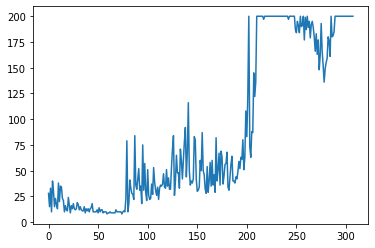

In [10]:
pd.Series(scores).plot()

In [ ]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [ ]:
print(env.reset())

[-0.0056831  -0.0062962  -0.02275845  0.04098642]


In [ ]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
dummy_agent = Agent(gamma = 0.99,epsilone=1,lr=lr,input_dims=env.observation_space.shape,
               n_actions=env.action_space.n,mem_size=1000000,batch_size=64,epsilone_end=0.01)

In [ ]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  observation = env.reset()
  for i in range(1, max_steps + 1):
    # state = tf.expand_dims(state, 0)
    action = agent.choose_action(observation)

    observation, _, done, _ = env.step(action)
    # state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, dummy_agent, 10000)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


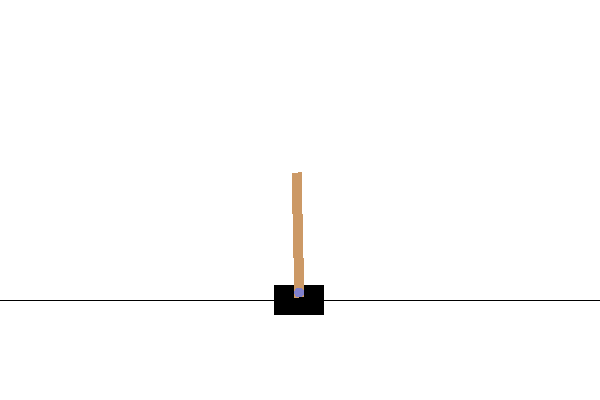

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)


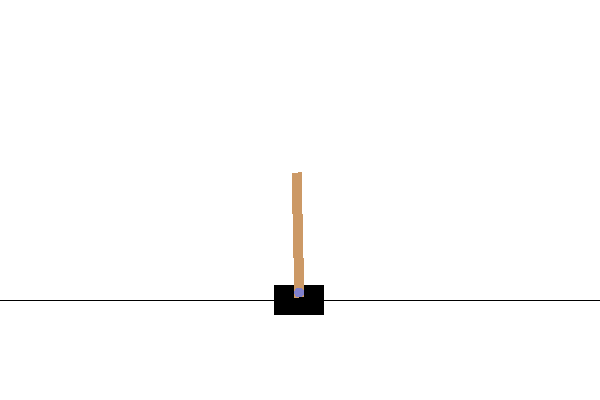

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)